### Imports

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

#gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

#model
from sklearn.cluster import KMeans

#### Jupyter Configuration

In [3]:
pd.options.display.max_colwidth = 100

### Analysing data

#### Loading CSV

In [47]:
#df = pd.read_csv('../raw_data/Tweets_Mg.csv', encoding='utf-8')
df = pd.read_csv('../raw_data/data/2014/DILMA_ROUSSEFF/#dilma/total_tweets.csv', encoding='utf-8')

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37157 entries, 0 to 37156
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              37157 non-null  object
 1   date             37157 non-null  object
 2   content          37157 non-null  object
 3   id               37157 non-null  int64 
 4   reply_count      37157 non-null  int64 
 5   retweet_count    37157 non-null  int64 
 6   like_count       37157 non-null  int64 
 7   quote_count      37157 non-null  int64 
 8   lang             37157 non-null  object
 9   username         37157 non-null  object
 10  displayname      37155 non-null  object
 11  description      27664 non-null  object
 12  verified         37157 non-null  bool  
 13  created          37157 non-null  object
 14  followers_count  37157 non-null  int64 
 15  friends_count    37157 non-null  int64 
 16  location         24131 non-null  object
 17  protected        37157 non-null

#### Cheking type of data and missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559591 entries, 0 to 559590
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   url              559591 non-null  object
 1   date             559591 non-null  object
 2   content          559591 non-null  object
 3   id               559591 non-null  int64 
 4   reply_count      559591 non-null  int64 
 5   retweet_count    559591 non-null  int64 
 6   like_count       559591 non-null  int64 
 7   quote_count      559591 non-null  int64 
 8   lang             559591 non-null  object
 9   username         559591 non-null  object
 10  displayname      559386 non-null  object
 11  description      450439 non-null  object
 12  verified         559591 non-null  bool  
 13  created          559591 non-null  object
 14  followers_count  559591 non-null  int64 
 15  friends_count    559591 non-null  int64 
 16  location         413345 non-null  object
 17  protected 

#### Dataset considerations

- Most of the content has NaN values
- 26 columns in total. 7 columns are object type, 2 columns are int type, 17 columns are float type
- 15 columns are complety empty, latitude and longitude only has 1% of values filled, the user location is present in 67% of the total rows

#### Check for unique values

In [7]:
df.nunique()

url                559591
date               540875
content            554047
id                 559591
reply_count           203
retweet_count         549
like_count           1075
quote_count           157
lang                   29
username           277959
displayname        222336
description        205779
verified                2
created            277744
followers_count     14264
friends_count        8267
location            55518
protected               1
profile_img        273092
query                   1
crawled_date            1
dtype: int64

In [8]:
df['location'].value_counts()

Brasil                          28186
Rio de Janeiro, Brasil          18079
São Paulo, Brasil               16599
Rio de Janeiro                   6764
Belo Horizonte, Brasil           6604
                                ...  
Serra Dourada 1                     1
feira de satanás                    1
República De Curitiba               1
Praia do Canto - Vitória -ES        1
‏زكواد                              1
Name: location, Length: 55518, dtype: int64

#### Observations

- There's 277959 unique users 49% of the total number of tweets observed
- The most common regions of the tweets are Brasil, Rio de Janeiro, São Paulo, Belo Horizonte respectively
- There's 29 different langs

### Data Cleaning

dropping all columns that:

- all null records
- less than 40% data
- all unique records such as id's

In [10]:
df = df[['date', 'content', 'location', 'username', 'retweet_count', 'lang']]

#### Removing duplicates based on Text

In [11]:
df = df.drop_duplicates(subset=['content'], keep='first')

In [12]:
df.shape

(554047, 6)

#### Defining a clean encoder

In [75]:
import re
import string

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import  make_column_transformer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 


class CleaningEncoder(BaseEstimator, TransformerMixin):
    '''
    Receives raw text data from the tweets and returns clean, ready to process data:
    turns all into lower case;
    removes punctuation;
    removes stopwords;
    removes numbers;
    removes users' handles
    
    '''
    def __init__(self):
        pass
                        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #assert isinstance(X, pd.DataFrame)
        X_ = X.copy()      
        
        #removin NaN values
        X_ = X_.fillna('nenhuma descrição')
        
        #removing links
        X_ = X_.apply(lambda x: re.sub(r"http\S+", "", x))
        X_ = X_.apply(lambda x: re.sub(r"www.\S+", "", x))
                
        #removing punctuation from each tweet
        new_punc = list(string.punctuation)
        del new_punc[2]
        del new_punc[-11]
        for punctuation in new_punc:
            X_ = X_.str.replace(punctuation, '')
            
        #removing numbers
        X_ = X_.str.replace('\d+', '')
        
        #tokenizing - removes handles, applies lowercase, keeps #, shortens letter repetitions to three
        #ex: kkkkk, kkkkkk, kkkkkkkkk = kkk
        tkn = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
        X_ = X_.apply(lambda x: tkn.tokenize(x))
        
        #removing stopwords
        stop_words = stopwords.words('portuguese')
        stop_words.remove('não')
        addicional = [
            'd', 'ta', 'q', 'tah', 'tao', 'eh', 'vc', 'voce',
            'pq', 'quedê', 'mto', 'mt', 'bj', 'bjs','vcs','bb',
            'b', 'sao', 'axo', 'mano', 'ae', 'neh', 'aí', '...', 'rt',
            'kkk', 'porque', 'né', 'no', 'iai', 'tbm', 'msm', 'jah']
        stop_words.extend(addicional)
        
        #X_ = X_.apply(lambda x: [word for word in x if len(word) > 1])
        X_ = X_.apply(lambda x: [word for word in x if word not in (stop_words)])
        #X_ = X_.apply(lambda x: ' '.join(word for word in x if word not in (stop_words)))
        
        return X_

#### Execute cleaning process on text column

In [76]:
clean = CleaningEncoder()

df['content_clean'] = clean.fit_transform(df['content'])

/tmp/ipykernel_17899/344343821.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_ = X_.str.replace(punctuation, '')
/tmp/ipykernel_17899/344343821.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_ = X_.str.replace(punctuation, '')
/tmp/ipykernel_17899/344343821.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_ = X_.str.replace(punctuation, '')
/tmp/ipykernel_17899/344343821.py:44: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character r

In [77]:
df['content_clean']

0         [lbe, liga, brasileira, epilepsia, saliva, eliminada, durante, convulsão, pode, transmitir, epil...
1                       [gostei, vídeo, freeza, juntos, maior, mito, torneio, react, ep, dragon, ball, super]
2                                                                                   [mito, cria, lixo, copia]
3                                                                                       [fábio, mito, santos]
4         [suspiro, morte, hc, aceito, ser, examinado, julgado, improcedente, aceitou, hc, exame, não, nec...
                                                         ...                                                 
559583                                                                        [vai, toma, cu, ale, mito, dms]
559584                                                                          [cadê, mito, anthony, bennet]
559585    [la, casa, papel, não, tão, bom, bolsonaro, não, mito, felipe, neto, bom, youtuber, ss, chato, c...
559586    

#### Removing duplicates again on cleaned data

In [17]:
df = df.drop_duplicates(subset=['content_clean'], keep='first')

In [18]:
df.shape

(455733, 7)

#### Converting Date column to DateTime Object and creating two new columns:month and year

In [20]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

/tmp/ipykernel_17899/3000405607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/tmp/ipykernel_17899/3000405607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month
/tmp/ipykernel_17899/3000405607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [21]:
df.head()

,date,content,location,username,retweet_count,lang,content_clean,month,year
0,2018-03-25 23:59:56,LBE - Liga Brasileira de Epilepsia - A SALIVA ELIMINADA DURANTE UMA CONVULSÃO PODE TRANSMITIR E...,NaN,lesbraga,0,pt,lbe liga brasileira epilepsia saliva eliminada durante convulsão pode transmitir epilepsia mito ...,3,2018
1,2018-03-25 23:59:52,"Gostei de um vídeo @YouTube https://t.co/B0lmQnr5jz E FREEZA JUNTOS, 17 O MAIOR MITO DO TORNEIO!...","Manaus, Amazonas",carloseduardofx,0,pt,gostei vídeo freeza juntos maior mito torneio react ep dragon ball super,3,2018
2,2018-03-25 23:59:19,"""O mito cria o lixo copia"" @SuarezAdryan https://t.co/yrdEuo37jC",en la panaderia,DanieIaTorress,0,pt,mito cria lixo copia,3,2018
3,2018-03-25 23:59:14,@espora13 @atletico Fábio Mito Santos,"Joaquim Felício, Brasil",w_martins1207,0,pt,fábio mito santos,3,2018
4,2018-03-25 23:58:24,"@RevistaISTOE Foi o suspiro da morte, o HC foi aceito para ser examinado, mas será julgado impro...",São Paulo - Brasil,DrJorgeSouza,0,pt,suspiro morte hc aceito ser examinado julgado improcedente aceitou hc exame não necessariamente ...,3,2018


#### Storing column 'Classificacao' as our y_pred

In [94]:
y_pred = df['Classificacao']
df.drop(columns=['Classificacao'], inplace=True)

KeyError: 'Classificacao'

### Feature Engineering

#### Converting the "text_clean" column in the format supported by embeddings.

In [25]:
sent = [row for row in df["content_clean"]]
#use Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
# phrases = Phrases(sent, min_count=1, progress_per=50000)
# bigram = Phraser(phrases)
# sentences = bigram[sent]

sentences = []
for i in range(0, len(sent)):
    sentences.append(sent[i].split(' '))

#sentences

In [26]:
#Initializing the word2vec model
w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size = 300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


#building vocab of the word2vec model from the custom data
w2v_model.build_vocab(sentences, progress_per=50000)

# https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483

In [27]:
#training the word2vec model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(50239794, 144268260)

In [29]:
# checking similar words in the corpus
w2v_model.wv.most_similar(positive=["haddad"])

[('poste', 0.7230837941169739),
 ('ciro', 0.6891016960144043),
 ('alckmin', 0.6444920301437378),
 ('pt', 0.642784833908081),
 ('alkimim', 0.6359413862228394),
 ('migrar', 0.6330007910728455),
 ('fantoche', 0.6314475536346436),
 ('falsiddad', 0.6226711869239807),
 ('hadadd', 0.6170825958251953),
 ('alckimin', 0.6161002516746521)]

In [30]:
#saving the word2vec model
w2v_model.save("../raw_data/word2vec_mito.model")

In [31]:
#Loading the word2vec model
word_vectors = Word2Vec.load("../raw_data/word2vec_mito.model").wv

In [32]:
#Feeding the embeddings to a KMeans model to cluster words into positive, negative, and neutral clusters
model = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [39]:
# check what we have in each cluster to label the clusters
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=50, restrict_vocab=None)

[('driblado', 0.8367975950241089),
 ('kimmich', 0.8314777612686157),
 ('mikel', 0.8310962319374084),
 ('robgol', 0.8291711211204529),
 ('#toques', 0.8277086615562439),
 ('dortmund', 0.827426552772522),
 ('nainggolan', 0.8251321911811829),
 ('hummels', 0.821873128414154),
 ('gooolaço', 0.8216712474822998),
 ('lingard', 0.8203548192977905),
 ('#chapecoense', 0.8190000057220459),
 ('lateralesquerda', 0.8156614899635315),
 ('dagol', 0.8150851726531982),
 ('latera', 0.8135048747062683),
 ('elber', 0.8111499547958374),
 ('#voltadedé', 0.8090506792068481),
 ('rashford', 0.8084550499916077),
 ('elano', 0.8069788813591003),
 ('#chelsea', 0.806922435760498),
 ('luverdense', 0.8052404522895813),
 ('#copadarussia', 0.8050856590270996),
 ('pirlo', 0.8047767877578735),
 ('alvez', 0.8047056198120117),
 ('favre', 0.804589033126831),
 ('#internacional', 0.8037655353546143),
 ('magistral', 0.8032668828964233),
 ('#europaleaguefoxsports', 0.8028940558433533),
 ('#vamoschape', 0.8025880455970764),
 ('#ynw

In [40]:
# Labelling the clusters based on the type of words they carry
positive_cluster_center = model.cluster_centers_[2]
negative_cluster_center = model.cluster_centers_[1]
neutral_cluster_center= model.cluster_centers_[0]

In [45]:
#Creating a DataFrame of words with their embeddings and cluster values
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)])[0])
#words.cluster = words.cluster.apply(lambda x: x[0])

# https://towardsdatascience.com/unsupervised-sentiment-analysis-a38bf1906483

In [46]:
#Assigning 1 to positive values, 0 to neutral and -1 for negative values
words['cluster_value'] = [1 if i==2 else 0 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [47]:
words[words["cluster_value"]==-1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
4435,macedo,"[-0.9511838, 0.17088418, 1.1510068, -0.32683194, 0.70824647, 0.39735875, -1.0071918, 0.8269708, ...",1,-1,0.061144
3478,➡,"[0.3078026, 1.1495196, -0.75883025, -2.341329, -0.922239, 0.43600276, 0.37474012, 0.4766863, 0.3...",1,-1,0.061352
4551,alfa,"[0.75527865, -0.8635013, -1.1809188, -1.2716343, -0.05506493, -0.8157928, -0.8137018, -1.1012603...",1,-1,0.061966
4514,❌,"[0.83721507, 0.6425181, -0.68736196, -0.008306345, 0.0049287067, 1.2814461, -0.6801033, 1.003745...",1,-1,0.063043
4322,pink,"[1.2337377, -0.46909922, -0.3673563, -0.13863601, 1.8599161, 0.22272739, -1.2119559, 0.054690212...",1,-1,0.064667
...,...,...,...,...,...
40024,nhaque,"[-0.037673008, 0.17514025, 0.03704484, 0.13963115, -0.17413656, -0.08245814, -0.10898298, 0.0520...",1,-1,2.182020
39467,vitinhomito,"[-0.021505695, 0.096253894, -0.0022764655, 0.087105386, -0.12680092, -0.082807496, -0.06263944, ...",1,-1,2.200795
36711,jotão,"[-0.03741928, 0.1604902, 0.0053357678, 0.105259955, -0.16930123, -0.107252166, -0.07869707, 0.04...",1,-1,2.254195
39900,boltao,"[-0.009817167, 0.13616337, -0.0034777739, 0.10908388, -0.15441588, -0.08677978, -0.07621147, 0.0...",1,-1,2.467461


In [57]:
positive = ['bom','limpo','caminhar','comunidade','ajudar',"saude","obter","leve","excelente",
            "surpreender", "brilhante", "incrivel", "ganhar", "melhor"]
neutral = ['pode','vai','vai','tem','clima','em','deve',"ele","acontece","mercearia","pessoa",'espaco','realmente',"tempo"]
negative= ['patetico','estupido','louco','idiota','insano','triste','durao','irritante']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"]=-1
    
for i in neutral:
    words.loc[words["words"]==i,"cluster_value"]=0
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"]=1

In [58]:
words[words["words"]=="insano"]

,words,vectors,cluster,cluster_value,closeness_score,sentiments
6148,insano,"[0.98187673, 0.57192445, 0.4287594, 0.65314126, 0.26426032, 0.92124045, -0.5305455, 0.29282057, ...",1,1,0.127825,negative


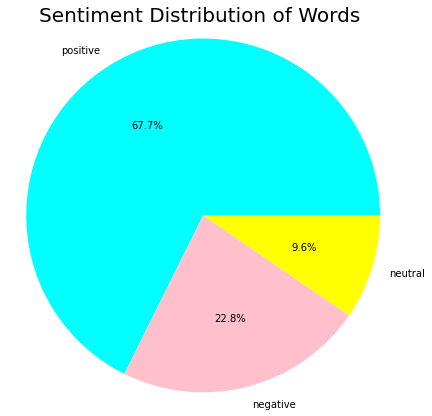

,index,sentiments
0,positive,30882
1,negative,10395
2,neutral,4366


In [59]:
# Plotting pie chart of Sentiment Distribution of words
emotion = {0: "neutral",
           -1: "positive",
           1: "negative"}

words["sentiments"]=words["cluster_value"].map(emotion)


fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"],labels=df_pie["index"],radius=2,colors=colors,autopct="%1.1f%%")
plt.axis('equal')
plt.title("Sentiment Distribution of Words ", fontsize=20)
plt.show()
df_pie

In [69]:
# define a function to get the sentiment for the entire tweet
def get_sentiments(x,sent_dict):
    '''
    x:         List
               Input data: Row of a DataFrame
    sent_dict: Dictionary
               Input: Dictionary of Words: Sentiments
    sentiment: String
               Output: Sentiment of the whole sentence
    
    Function: Getting sentiments of the entire sentence by averaging out the sentiments of individual words
    '''
    total=0
    count=0
    avg = 0
    test=x["content_clean"]
    for t in test:
        if words_dict.get(t):
            total+=int(sent_dict.get(t))
        count+=1 
    if total > 0:
        avg=total/count
    sentiment=1 if avg<-0.15 else -1 if avg >0.15 else 0
    return sentiment

In [70]:
# creating a dictionary of the word and its cluster value
words_dict = dict(zip(words.words, words.cluster_value))

#words_dict

In [73]:
# adding sentiment column
df["sentiment"]=df.apply(get_sentiments,args=(words_dict,),axis=1)

In [72]:
df["sentiment"].value_counts()

 0    455660
-1        73
Name: sentiment, dtype: int64

In [74]:
df.head()

,date,content,location,username,retweet_count,lang,content_clean,month,year,sentiment
0,2018-03-25 23:59:56,LBE - Liga Brasileira de Epilepsia - A SALIVA ELIMINADA DURANTE UMA CONVULSÃO PODE TRANSMITIR E...,NaN,lesbraga,0,pt,lbe liga brasileira epilepsia saliva eliminada durante convulsão pode transmitir epilepsia mito ...,3,2018,0
1,2018-03-25 23:59:52,"Gostei de um vídeo @YouTube https://t.co/B0lmQnr5jz E FREEZA JUNTOS, 17 O MAIOR MITO DO TORNEIO!...","Manaus, Amazonas",carloseduardofx,0,pt,gostei vídeo freeza juntos maior mito torneio react ep dragon ball super,3,2018,0
2,2018-03-25 23:59:19,"""O mito cria o lixo copia"" @SuarezAdryan https://t.co/yrdEuo37jC",en la panaderia,DanieIaTorress,0,pt,mito cria lixo copia,3,2018,0
3,2018-03-25 23:59:14,@espora13 @atletico Fábio Mito Santos,"Joaquim Felício, Brasil",w_martins1207,0,pt,fábio mito santos,3,2018,0
4,2018-03-25 23:58:24,"@RevistaISTOE Foi o suspiro da morte, o HC foi aceito para ser examinado, mas será julgado impro...",São Paulo - Brasil,DrJorgeSouza,0,pt,suspiro morte hc aceito ser examinado julgado improcedente aceitou hc exame não necessariamente ...,3,2018,0
